In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import floor
use_cuda = True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/APS360/Project/train.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
# Normal dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    # transforms.ColorJitter(hue=.05, saturation=.05),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
    # transforms.GaussianBlur(kernel_size, sigma=(0.1, 2.0))
])

# Horizontally flipped
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(1.0) # Flip all the images
])

# Gaussian Blur
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.GaussianBlur(11, sigma=10.0)
])

# Brightness changed
transform4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2),
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/tmp/train', transform=transform)

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

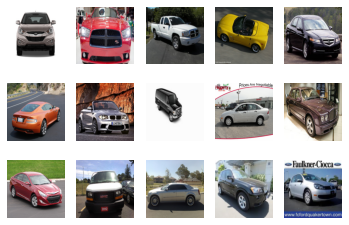

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in loader:
    # since batch_size = 1, there is only 1 image in `images`
    img = images[0]

    # place the colour channel at the end, instead of at the beginning
    img = img.permute(1,2,0)
    # normalize pixel intensity values to [0, 1]
    # img = img / 2 + 0.5



    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
class CNN (nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.name = "CNN"
    kernel = [5, 5]
    self.conv1 = nn.Conv2d(3, 5, kernel[0])
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 10, kernel[1])
    a = floor((224 - kernel[0])/2) + 1 
    b = floor((a - kernel[1])/2) + 1 
    self.fc1_in = 10 * b * b


    self.fc1 = nn.Linear(self.fc1_in, 30) 
    self.fc2 = nn.Linear(30, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,self.fc1_in) 
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

def train(model, trainset, validset, testset, test = True, batch_size=50, num_epochs=30, learn_rate=0.001):

  num_workers = 1
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=num_workers, shuffle=True)


  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learn_rate)
  train_loss = np.zeros(num_epochs)
  train_acc = np.zeros(num_epochs)
  valid_acc = np.zeros(num_epochs)
  test_acc = np.zeros(num_epochs)

  for epoch in range (num_epochs):
    for imgs, labels in iter(train_loader):
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

    train_acc[epoch] = get_accuracy(model, train_loader)
    train_loss[epoch] = float(loss)
    valid_acc[epoch] = get_accuracy(model, valid_loader)
    test_acc[epoch] = get_accuracy(model, test_loader)
    epochs = np.arange(1, num_epochs + 1)  

    if(test):
      print(("Epoch {}: " + "Training loss: {} | Training acc: {} |" + "Validation acc: {} |" + "Testing acc: {}").format(epoch, train_loss[epoch], train_acc[epoch], valid_acc[epoch], test_acc[epoch]))
    else:
      print(("Epoch {}: " + "Training loss: {} | Training acc: {} |" + "Validation acc: {} ").format(epoch, train_loss[epoch], train_acc[epoch], valid_acc[epoch]))

  if(test):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Validation Curve")
    plt.plot(epochs, valid_acc, label="Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Validation accuracy")

    plt.subplot(1,2,2)
    plt.title("Testing Curve")
    plt.plot(epochs, test_acc, label="Testing Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Testing Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))
    print("Final Testing Accuracy: {}".format(test_acc[-1]))

  else:
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")

    plt.subplot(1,3,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")

    plt.subplot(1,3,3)
    plt.title("Validation Curve")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))


def get_accuracy(model, data):
  correct = 0
  total = 0
  model.eval()
  for imgs, labels in data:

    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

Overfitted model for train-mini containing only 9 labels.

In [ ]:
# Loading Gesture Images from Google Drive
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])


# location on Google Drive
train_path = '/content/gdrive/MyDrive/APS360/Project/train_mini'

# Load data from Google Drive
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform)

valid_dataset = train_dataset
test_dataset = train_dataset
torch.manual_seed(10)
model = CNN()
if use_cuda and torch.cuda.is_available():
  print('Using cuda')
  model.cuda()
  
train(model, train_dataset, valid_dataset, test_dataset, False, 20, 15)